In [178]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import dask
import time
import shutil
import zarr

import warnings
import intake
import pathlib
import cftime
import xarray as xr

import matplotlib.pyplot as plt
from fastjmd95 import rho
import fastjmd95
from rechunker.api import rechunk
assert fastjmd95.__version__ >= "0.2.1"

from multiprocessing.pool import ThreadPool
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

from xgcm import Grid
from fastprogress.fastprogress import progress_bar

from xarrayutils.file_handling import (
    write,
    maybe_create_folder,
    file_exist_check,
    temp_write_split,
)
from xarrayutils.utils import remove_bottom_values

from cmip6_preprocessing.preprocessing import (
    combined_preprocessing
)
from cmip6_preprocessing.drift_removal import (
    remove_trend
)
from cmip6_preprocessing.utils import (
    cmip6_dataset_id
)

import sys
sys.path.append("../../")
from cmip6_omz.upstream_stash import (
    xgcm_transform_wrapper as transform_wrapper,
)
from cmip6_omz.omz_tools import (
    volume_consistency_checks,
    omz_thickness,  
)
from cmip6_omz.utils import (
    cmip6_collection,
)



#from aguadv_omz_busecke_2021.utils import print_html
from aguadv_omz_busecke_2021.preprocessing import (
    mixed_layer_wrapper,
    save_and_reload_rechunker,
    #preprocessing_wrapper,
    strip_encoding,
)
from aguadv_omz_busecke_2021.omz_tools import (
    plot_omz_results,
#    mask_basin,
)
#
#
#from aguadv_omz_busecke_2021.cmip6_stash import (
#    detrend,
#    construct_cfdate,
#    _get_calendar,
#    cmip6_dataset_id,
#    combined_preprocessing,
#    load_single_datasets,
#    nested_dataset_wrapper,
#    match_and_detrend,
#    combine_grid_labels,
#    parse_metrics,
#)

dask.config.set(pool=ThreadPool(32))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Develop functions here

In [160]:
#This could go upstream in a more general form
## but for now let's keep it here and readable
def transform_wrapper_again(
    ds_in,
    intensive_vars=[
        "thetao",
        "o2",
        "so",
        "agessc",
    ],
):
    # alternate name: transform mean wrapper
    # sigma_bins
    sigma_bins = np.array([0, 24.5, 26.5, 27.65, 100])

    # define variables to be averaged (intensive quantities)
    intensive_vars = [
        "thetao",
        "o2",
        "so",
        "agessc",
    ]  # add 'uo', 'agessc' etc?

    intensive_vars = [v for v in intensive_vars if v in ds_in.data_vars]

    for iv in intensive_vars:
        dz = (xr.ones_like(ds_in[iv]) * ds_in.dz_t).where(~np.isnan(ds_in[iv]))
        ds_in[iv] = ds_in[iv] * dz

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ds_out = transform_wrapper(
            ds_in,
            extensive_vars=["omz_thickness"] + intensive_vars,
            target=sigma_bins,
        )

    # reconvert the same variables
    dz = ds_out.dz_t
    for iv in intensive_vars:
        ds_out[iv] = ds_out[iv] / dz
    return ds_out

In [162]:
#These functions make up the matching and detrending
#going to upstream stash
def construct_cfdate(data, units, calendar):

    date = xr.DataArray(data, attrs={"units": units, "calendar": calendar})
    return xr.decode_cf(date.to_dataset(name="time"), use_cftime=True).time

def _get_calendar(time):
    ### This assumes that the time is decoded already
    return time.encoding.get("calendar", "standard")


def match_and_detrend(data_dict, trend_dict, pass_variables=[], verbose=False):
    """
    Takes CMIP6 datasets dict and a dictionary of trend datasets, and returns the detrended datasets.
    Datasets with variable in `pass_variables` are passed through unaltered.
    """
    sep='_'
    
    compare_attrs = [ #should version_id also be here?
        "source_id",
        "table_id",
        "grid_label",
        "variant_label",
        "variable_id",
    ]


    data_dict_detrended = {}
    for name, ds in data_dict.items():
        ds = ds.copy()
        if ds.attrs["variable_id"] in pass_variables:
            if verbose:
                print(f"Manually Ignored Variable: Passing {name} unaltered")
            data_dict_detrended[name] = ds
        elif ds.attrs["experiment_id"] == "piControl": 
            if verbose:
                print(f"Control run: Passing {name} unaltered")
            data_dict_detrended[name] = ds
        else:
            match_elements = [ds.attrs[i] for i in compare_attrs]
            match_targets = list(trend_dict.keys()) #use attr once trend files preserve them
            match_trend_names = [
                m for m in match_targets if all([me+sep in m for me in match_elements])
            ]
            if len(match_trend_names) == 1:
                trend_ds = trend_dict[match_trend_names[0]]

                ref_date = construct_cfdate(
                    0, "hours since 1850-1-15", _get_calendar(ds.time)
                ).data.tolist()
                
                #should this be handled elsewhere?
                if "slope" in trend_ds.vars:
                    trend_ds = trend_ds.rename({"slope":ds.attrs["variable_id"]})
                
                da_detrended = remove_trend(
                    ds, 
                    trend_ds,
                    ds.attrs["variable_id"],
                    ref_date=ref_date
                )
                ds[ds.attrs["variable_id"]] = da_detrended.reset_coords(drop=True)
                data_dict_detrended[name] = ds
                
                ds.attrs["detrended_with_file"] = 'Done'
                
            elif len(match_trend_names) > 1:
                raise ValueError(f"Found multiple matches for {match_elements}: {match_trend_names}. Check input")
            else:
                warnings.warn(f"No match found for {match_elements}.")
    return data_dict_detrended

In [6]:
def resample_yearly(ds_in, freq="1AS"):
    # this drops some coordinates, so i need to convert them to data_vars and then reconvert
    time_coords = [
        co
        for co in list(ds_in.coords)
        if "time" in ds_in[co].dims and co not in ["time", "time_bounds"]
    ]
    ds_out = ds_in.reset_coords(time_coords).resample(time=freq).mean()
    ds_out = ds_out.assign_coords({co: ds_out[co] for co in time_coords})
    ds_out.attrs.update({k: v for k, v in ds_in.attrs.items() if k not in ["table_id"]})
    return ds_out


def align_missing(ds_in):
    """Make sure that nans in all fields of a dataset are consistent.
    Requires"""
    # Due to the interpolation between `gr` and `gn`, we have to make sure that all data variables are masked in the same way!

    ds_mask = ds_in
    # for generalization np.logical_or.reduce((x, y, z))https://stackoverflow.com/questions/20528328/numpy-logical-or-for-more-than-two-arguments
    combo_nanmask = np.logical_or(
        np.isnan(ds_mask.o2).all("time").load(),
        np.isnan(ds_mask.thetao).all("time").load(),
    )
    try:
        plt.figure()
        combo_nanmask.isel(lev=5).plot()
        plt.show()
    except:
        pass

    ds_out = ds_in.where(~combo_nanmask)

    return ds_out

In [181]:
def preprocessing_wrapper(ds_in):
    
    # fix the attribute parsed by intake-esm
    for k,v in ds_in.attrs.items():
        if v is None:
            print(f"Replacing {k} attrs value with `none`")
            ds_in.attrs[k] = 'none'
            
    ds_in = strip_encoding(ds_in)
    
    if 'member_id' in ds_in.dims:
        if isinstance(ds_in.member_id.data, object):
            ds_in['member_id'] = ds_in['member_id'].astype(str)

    # strip all the coords to avoid trouble
    delete_coords = [
        "branch_time_in_parent",
        "branch_time_in_child",
        "parent_time_units",
        "child_time_units",
        "parent_variant_label",  # these are all scalar coords (and zarr doesnt like those?)
        "time_bounds",  # this is a bit different one, but makes trouble as a coordinate?
    ]

    ds_out = ds_in.drop([co for co in ds_in.coords if co in delete_coords])

    # see below. Make a new fake 'outer' coordinate. I think the values really dont matter?
    ds_out = ds_out.assign_coords(
        lev_outer=np.hstack(
            [0, (ds_out.lev.data[1:] + ds_out.lev.data[0:-1]) / 2, 5e10]
        )
    )
    return ds_out

# Start pipeline here

In [163]:
foldername = "density_remapping_time_yearly_final"
ofolder = maybe_create_folder(f"../../data/processed/{foldername}")
tempfolder = maybe_create_folder(f"../../data/temp/scratch_temp/{foldername}")

# global parameters
o2_bins = np.array([10, 40, 60, 80, 100, 120])

/home/samjd/anaconda3/envs/cmip6_omz/lib/python3.9/site-packages/xarrayutils/file_handling.py:118: UserWarning: Folder ../../data/processed/density_remapping_time_yearly_final does already exist.
  warnings.warn(f"Folder {path} does already exist.", UserWarning)
/home/samjd/anaconda3/envs/cmip6_omz/lib/python3.9/site-packages/xarrayutils/file_handling.py:118: UserWarning: Folder ../../data/temp/scratch_temp/density_remapping_time_yearly_final does already exist.
  warnings.warn(f"Folder {path} does already exist.", UserWarning)


In [164]:
#for some reason jupyter.rc has trouble reading from /home/ on tigress
#even if it is symlinked elsewhere
#so using google storage catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col.df['source_id'].unique()

array(['CMCC-CM2-HR4', 'EC-Earth3P-HR', 'HadGEM3-GC31-MM',
       'HadGEM3-GC31-HM', 'HadGEM3-GC31-LM', 'EC-Earth3P', 'ECMWF-IFS-HR',
       'ECMWF-IFS-LR', 'HadGEM3-GC31-LL', 'CMCC-CM2-VHR4', 'GFDL-CM4',
       'GFDL-AM4', 'IPSL-CM6A-LR', 'E3SM-1-0', 'CNRM-CM6-1', 'GFDL-ESM4',
       'GFDL-ESM2M', 'GFDL-CM4C192', 'GFDL-OM4p5B', 'GISS-E2-1-G',
       'GISS-E2-1-H', 'CNRM-ESM2-1', 'BCC-CSM2-MR', 'BCC-ESM1', 'MIROC6',
       'AWI-CM-1-1-MR', 'EC-Earth3-LR', 'IPSL-CM6A-ATM-HR', 'CESM2',
       'CESM2-WACCM', 'CNRM-CM6-1-HR', 'MRI-ESM2-0', 'CanESM5',
       'SAM0-UNICON', 'GISS-E2-1-G-CC', 'UKESM1-0-LL', 'EC-Earth3',
       'EC-Earth3-Veg', 'FGOALS-f3-L', 'CanESM5-CanOE', 'INM-CM4-8',
       'INM-CM5-0', 'NESM3', 'MPI-ESM-1-2-HAM', 'CAMS-CSM1-0',
       'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'MRI-AGCM3-2-S', 'MRI-AGCM3-2-H',
       'MCM-UA-1-0', 'INM-CM5-H', 'KACE-1-0-G', 'NorESM2-LM',
       'FGOALS-f3-H', 'FGOALS-g3', 'MIROC-ES2L', 'FIO-ESM-2-0', 'NorCPM1',
       'NorESM1-F', 'MPI-ESM1-2-XR'

In [165]:
#We are replacing load_single_datasets wrapper from old pipeline
#with some unwrapped commands...

z_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}
variable_ids = ["thetao", "so", "o2", "mlotst", "agessc", "thkcello", "areacello"]
#for now let's just try CanESM5 to test pipeline
cat = col.search(
    source_id=["CanESM5"], #ACCESS-ESM1-5
    grid_label=["gr", "gn"],
    experiment_id=["historical"],
    table_id=["Omon", "Ofx"],
    variable_id=variable_ids,
    member_id = ['r1i1p2f1'] #test pipeline with single member
)

def thin_wrapper(ds):
    ds = combined_preprocessing(ds)
    ds = ds.drop([va for va in ds.data_vars if va not in [ds.attrs["variable_id"]]])
    return ds

ds_dict = cat.to_dataset_dict(
        aggregate=False,
        zarr_kwargs=z_kwargs,
        preprocess=thin_wrapper,
    )


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [166]:
#Fudging this run a bit because the variable fields are spread over two different versions
#We need a way to only keep members with a full set of variables from a single version?

keep_vars = variable_ids.copy()
version_sel_helper = []
ds_dict_ = {}
for name, ds in ds_dict.items():
    version_sel_helper.append(int(ds.attrs['version_id'].replace('v','')))
version_sel = max(version_sel_helper)

for name, ds in ds_dict.items():
    if str(version_sel) in ds.attrs['version_id']:
        if ds.attrs['variable_id'] in keep_vars:
            #if 'historical' in ds.attrs['experiment_id']:
            ds_dict_[name] = ds
            keep_vars.remove(ds.attrs['variable_id'])

In [167]:
for names, ds in ds_dict_.items():
    print(ds.attrs['variable_id'])

areacello
thetao
mlotst
agessc
so
thkcello
o2


In [168]:
#for some reason jupyter.rc has trouble reading from /home/ on tigress
#even if it is symlinked elsewhere
#so had to physically move the needed files here, which isn't great

trendfolder = pathlib.Path('../../data/processed/linear_regression_time_zarr_multimember/')
trend_models = np.unique([ds.attrs['source_id'] for ds in ds_dict_.values()])
flist = []
for tm in trend_models:
    flist = flist + list(trendfolder.glob(f'*{tm}*_trend.nc'))

total = len(flist)
progress = progress_bar(range(total))

trend_dict = {}
for i,path in enumerate(flist):
    key = path.stem
    ds = xr.open_mfdataset([path])
    # write the filename in the dataset
    ds.attrs.update({'filepath':str(path)})
    # exclude all nan slopes (why are these there in the first place?)
    if not np.isnan(ds.slope).all():
        trend_dict[key] = ds
    else:
        print(f"found all nan regression data for {path}")
    progress.update(i)
progress.update(total)

In [169]:
#error was triggered in line 350 of cmip6_preprocessing.drift_removal
#this is a temporary workaround
for name, ds in trend_dict.items():
    trend_dict[name] = ds.drop('trend_time_range')

In [170]:
ddict_detrended = match_and_detrend(
    ds_dict_,
    trend_dict,
    verbose=True,
    pass_variables=["areacello", "thkcello", "mlotst"],
)

Manually Ignored Variable: Passing CMIP.CCCma.CanESM5.historical.r1i1p2f1.Ofx.areacello.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p2f1/Ofx/areacello/gn/v20190429/.nan.20190429 unaltered


/home/samjd/anaconda3/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/drift_removal.py:356: UserWarning: `ds_slope` did not have information about the time over which the slope was calculated. Check the input.
  warnings.warn(


Manually Ignored Variable: Passing CMIP.CCCma.CanESM5.historical.r1i1p2f1.Omon.mlotst.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p2f1/Omon/mlotst/gn/v20190429/.nan.20190429 unaltered


/home/samjd/anaconda3/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/drift_removal.py:356: UserWarning: `ds_slope` did not have information about the time over which the slope was calculated. Check the input.
  warnings.warn(
/home/samjd/anaconda3/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/drift_removal.py:356: UserWarning: `ds_slope` did not have information about the time over which the slope was calculated. Check the input.
  warnings.warn(


Manually Ignored Variable: Passing CMIP.CCCma.CanESM5.historical.r1i1p2f1.Ofx.thkcello.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p2f1/Ofx/thkcello/gn/v20190429/.nan.20190429 unaltered


/home/samjd/anaconda3/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/drift_removal.py:356: UserWarning: `ds_slope` did not have information about the time over which the slope was calculated. Check the input.
  warnings.warn(


## See if files are actually detrended

In [172]:
detrended_names = []
for name, ds in ddict_detrended.items():
    if ds.attrs['variable_id'] == 'o2':
        ds_detrnd = ddict_detrended[name]
        ds_orig = ds_dict_[name]
           
orig_o2 = np.nanmean(ds_orig.o2.isel(x = 100, y = 220).data, axis = 1)[-200:] #just look at last 200 months
detrnd_o2 = np.nanmean(ds_detrnd.o2.isel(x = 100, y = 220).data, axis = 1)[-200:]

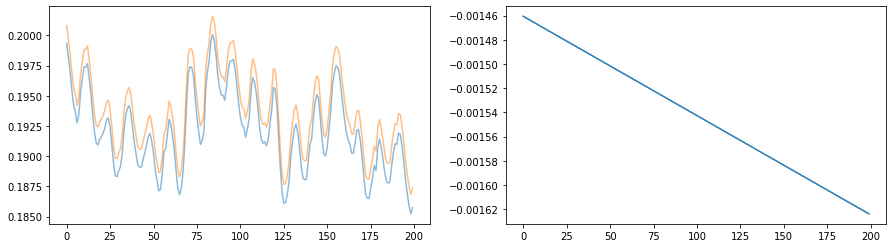

In [173]:
fig, ax = plt.subplots(1,2,figsize = (15, 4))
ax[0].plot(np.arange(len(orig_o2)), orig_o2, alpha = 0.5, label = 'original')
ax[0].plot(np.arange(len(detrnd_o2)), detrnd_o2, alpha = 0.5, label = 'detrended')

ax[1].plot(np.arange(len(orig_o2)), orig_o2 - detrnd_o2, label = 'recovered slope')

In [174]:
ddict_detrended_filtered = {k:v for k,v in ddict_detrended.items() if 'rho' not in v.dims}

In [175]:
#Goal is to get this working
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
#    ddict_nested = comb_grid_labels_wrapper(ddict_detrended_filtered)

In [177]:
#rechunk to make sure all chunks are even
for name, ds in ddict_detrended_filtered.items():
    if 'time' in ds.dims:
        ddict_detrended_filtered[name] = ds.chunk(chunks={'time':5})
#manually merge
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ds_nested = xr.merge([ddict_detrended_filtered[key] for key in ddict_detrended_filtered.keys()])
    
ds_nested = ds_nested.rename({'thkcello': 'dz_t'})
ddict_detrended = {'CanESM5':ds_nested}

## Something is going wrong in this last step. The dataset looks fine going in, but somehow the variables are all set to zero somewhere here. So ds_sigma_monthly comes out with all 0 values. 

@@@@@@@@@@@@@@@@@
Processing CanESM5
@@@@@@@@@@@@@@@@@
Writing to ../../data/processed/density_remapping_time_yearly_final/CMIP.CCCma.CanESM5.historical.r1i1p2f1.Ofx.gn.v20190429_r1i1p2f1.zarr


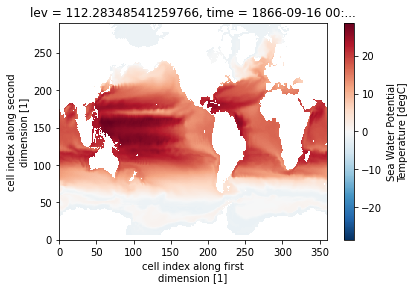

areacello
thetao
agessc
so
dz_t
o2
First temp save
 Split indicies: [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080, 1200, 1320, 1440, 1560, 1680, 1800, 1920, None]


Rechunking incoming dataset
Intermediate save 188.35347146 GB
Rechunking to: {'agessc': (12, 45, 202, 360), 'areacello': (12, 202, 360), 'dz_t': (12, 45, 202, 360), 'mlotst': (12, 202, 360), 'o2': (12, 45, 202, 360), 'so': (12, 45, 202, 360), 'thetao': (12, 45, 202, 360), 'bnds': (1,), 'lat': (202, 360), 'lat_bounds': (1, 202, 360), 'lat_verticies': (202, 360, 1), 'lev': (45,), 'lev_bounds': (45, 1), 'lev_outer': (46,), 'lon': (202, 360), 'lon_bounds': (1, 202, 360), 'lon_verticies': (202, 360, 1), 'time': (12,), 'vertex': (1,), 'x': (360,), 'y': (202,)}
[                                        ] | 0% Completed |  0.0s_copy_chunk((slice(0, 5, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[                                        ] | 0% Completed |  0.1s_copy_chunk((slice(5, 10, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(10, 15, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[                    

_copy_chunk((slice(275, 280, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[                                        ] | 1% Completed |  3.6s_copy_chunk((slice(280, 285, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[                                        ] | 1% Completed |  3.7s_copy_chunk((slice(285, 290, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(290, 295, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[                                        ] | 1% Completed |  3.8s_copy_chunk((slice(295, 300, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[                                        ] | 2% Completed |  3.9s_copy_chunk((slice(300, 305, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(305, 310, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[                                        ] | 2%

_copy_chunk((slice(565, 570, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#                                       ] | 3% Completed |  7.5s_copy_chunk((slice(570, 575, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#                                       ] | 3% Completed |  7.6s_copy_chunk((slice(575, 580, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(580, 585, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#                                       ] | 3% Completed |  7.7s_copy_chunk((slice(585, 590, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(590, 595, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#                                       ] | 4% Completed |  7.8s_copy_chunk((slice(595, 600, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#                                       ] | 4%

_copy_chunk((slice(855, 860, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##                                      ] | 5% Completed | 11.3s_copy_chunk((slice(860, 865, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##                                      ] | 5% Completed | 11.4s_copy_chunk((slice(865, 870, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(870, 875, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##                                      ] | 5% Completed | 11.5s_copy_chunk((slice(875, 880, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##                                      ] | 5% Completed | 11.6s_copy_chunk((slice(880, 885, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(885, 890, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##                                      ] | 6%

[###                                     ] | 7% Completed | 15.0s_copy_chunk((slice(1145, 1150, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1150, 1155, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###                                     ] | 7% Completed | 15.1s_copy_chunk((slice(1155, 1160, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###                                     ] | 7% Completed | 15.2s_copy_chunk((slice(1160, 1165, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1165, 1170, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###                                     ] | 7% Completed | 15.3s_copy_chunk((slice(1170, 1175, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###                                     ] | 7% Completed | 15.4s_copy_chunk((slice(1175, 1180, None), slice(0, 45, None), slice(0, 29

_copy_chunk((slice(1430, 1435, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###                                     ] | 9% Completed | 18.9s_copy_chunk((slice(1435, 1440, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###                                     ] | 9% Completed | 19.0s_copy_chunk((slice(1440, 1445, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1445, 1450, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###                                     ] | 9% Completed | 19.1s_copy_chunk((slice(1450, 1455, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###                                     ] | 9% Completed | 19.2s_copy_chunk((slice(1455, 1460, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1460, 1465, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###                             

_copy_chunk((slice(1715, 1720, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####                                    ] | 11% Completed | 22.6s_copy_chunk((slice(1720, 1725, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####                                    ] | 11% Completed | 22.7s_copy_chunk((slice(1725, 1730, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1730, 1735, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####                                    ] | 11% Completed | 22.8s_copy_chunk((slice(1735, 1740, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####                                    ] | 11% Completed | 22.9s_copy_chunk((slice(1740, 1745, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1745, 1750, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####                        

[#####                                   ] | 13% Completed | 26.7s_copy_chunk((slice(20, 25, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#####                                   ] | 13% Completed | 27.0s_copy_chunk((slice(25, 30, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#####                                   ] | 13% Completed | 27.2s_copy_chunk((slice(30, 35, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#####                                   ] | 13% Completed | 27.4s_copy_chunk((slice(35, 40, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#####                                   ] | 13% Completed | 27.5s_copy_chunk((slice(40, 45, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#####                                   ] | 13% Completed | 27.7s_copy_chunk((slice(45, 50, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#####                

[######                                  ] | 15% Completed | 36.0s_copy_chunk((slice(270, 275, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######                                  ] | 15% Completed | 36.2s_copy_chunk((slice(275, 280, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######                                  ] | 15% Completed | 36.4s_copy_chunk((slice(280, 285, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######                                  ] | 15% Completed | 36.5s_copy_chunk((slice(285, 290, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######                                  ] | 15% Completed | 36.8s_copy_chunk((slice(290, 295, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######                                  ] | 15% Completed | 37.0s_copy_chunk((slice(295, 300, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######   

[######                                  ] | 16% Completed | 45.7s_copy_chunk((slice(520, 525, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######                                  ] | 17% Completed | 45.9s_copy_chunk((slice(525, 530, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######                                  ] | 17% Completed | 46.1s_copy_chunk((slice(530, 535, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######                                  ] | 17% Completed | 46.3s_copy_chunk((slice(535, 540, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######                                  ] | 17% Completed | 46.5s_copy_chunk((slice(540, 545, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######                                  ] | 17% Completed | 46.7s_copy_chunk((slice(545, 550, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######   

[#######                                 ] | 18% Completed | 55.4s_copy_chunk((slice(770, 775, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#######                                 ] | 18% Completed | 55.6s_copy_chunk((slice(775, 780, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#######                                 ] | 18% Completed | 55.8s_copy_chunk((slice(780, 785, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#######                                 ] | 18% Completed | 56.0s_copy_chunk((slice(785, 790, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#######                                 ] | 18% Completed | 56.1s_copy_chunk((slice(790, 795, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#######                                 ] | 18% Completed | 56.3s_copy_chunk((slice(795, 800, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#######  

[########                                ] | 20% Completed |  1min  4.4s_copy_chunk((slice(1015, 1020, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[########                                ] | 20% Completed |  1min  4.6s_copy_chunk((slice(1020, 1025, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[########                                ] | 20% Completed |  1min  4.8s_copy_chunk((slice(1025, 1030, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[########                                ] | 20% Completed |  1min  4.9s_copy_chunk((slice(1030, 1035, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[########                                ] | 20% Completed |  1min  5.1s_copy_chunk((slice(1035, 1040, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[########                                ] | 20% Completed |  1min  5.3s_copy_chunk((slice(1040, 1045, None), slice(0, 45, None), slice

[#########                               ] | 22% Completed |  1min 18.0s_copy_chunk((slice(1365, 1370, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########                               ] | 22% Completed |  1min 18.2s_copy_chunk((slice(1370, 1375, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########                               ] | 22% Completed |  1min 18.4s_copy_chunk((slice(1375, 1380, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########                               ] | 22% Completed |  1min 18.6s_copy_chunk((slice(1380, 1385, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########                               ] | 22% Completed |  1min 18.8s_copy_chunk((slice(1385, 1390, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########                               ] | 22% Completed |  1min 18.9s_copy_chunk((slice(1390, 1395, None), slice(0, 45, None), slice

[#########                               ] | 24% Completed |  1min 26.6s_copy_chunk((slice(1600, 1605, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########                               ] | 24% Completed |  1min 26.8s_copy_chunk((slice(1605, 1610, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########                               ] | 24% Completed |  1min 26.9s_copy_chunk((slice(1610, 1615, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########                               ] | 24% Completed |  1min 27.1s_copy_chunk((slice(1615, 1620, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########                               ] | 24% Completed |  1min 27.3s_copy_chunk((slice(1620, 1625, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########                               ] | 24% Completed |  1min 27.4s_copy_chunk((slice(1625, 1630, None), slice(0, 45, None), slice

[##########                              ] | 25% Completed |  1min 34.8s_copy_chunk((slice(1835, 1840, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##########                              ] | 25% Completed |  1min 35.0s_copy_chunk((slice(1840, 1845, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##########                              ] | 26% Completed |  1min 35.2s_copy_chunk((slice(1845, 1850, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##########                              ] | 26% Completed |  1min 35.3s_copy_chunk((slice(1850, 1855, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##########                              ] | 26% Completed |  1min 35.5s_copy_chunk((slice(1855, 1860, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##########                              ] | 26% Completed |  1min 35.7s_copy_chunk((slice(1860, 1865, None), slice(0, 45, None), slice

[###########                             ] | 27% Completed |  1min 43.3s_copy_chunk((slice(95, 100, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###########                             ] | 27% Completed |  1min 43.5s_copy_chunk((slice(100, 105, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###########                             ] | 27% Completed |  1min 43.7s_copy_chunk((slice(105, 110, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###########                             ] | 27% Completed |  1min 43.8s_copy_chunk((slice(110, 115, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###########                             ] | 27% Completed |  1min 44.0s_copy_chunk((slice(115, 120, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###########                             ] | 27% Completed |  1min 44.2s_copy_chunk((slice(120, 125, None), slice(0, 45, None), slice(0, 291, None

[###########                             ] | 29% Completed |  1min 55.2s_copy_chunk((slice(335, 340, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###########                             ] | 29% Completed |  1min 55.4s_copy_chunk((slice(340, 345, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###########                             ] | 29% Completed |  1min 55.6s_copy_chunk((slice(345, 350, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###########                             ] | 29% Completed |  1min 55.7s_copy_chunk((slice(350, 355, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###########                             ] | 29% Completed |  1min 55.9s_copy_chunk((slice(355, 360, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###########                             ] | 29% Completed |  1min 56.1s_copy_chunk((slice(360, 365, None), slice(0, 45, None), slice(0, 291, Non

[############                            ] | 30% Completed |  2min  3.8s_copy_chunk((slice(575, 580, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[############                            ] | 30% Completed |  2min  4.0s_copy_chunk((slice(580, 585, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[############                            ] | 30% Completed |  2min  4.1s_copy_chunk((slice(585, 590, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[############                            ] | 30% Completed |  2min  4.3s_copy_chunk((slice(590, 595, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[############                            ] | 30% Completed |  2min  4.5s_copy_chunk((slice(595, 600, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[############                            ] | 31% Completed |  2min  4.7s_copy_chunk((slice(600, 605, None), slice(0, 45, None), slice(0, 291, Non

[############                            ] | 32% Completed |  2min 12.4s_copy_chunk((slice(815, 820, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#############                           ] | 32% Completed |  2min 12.5s_copy_chunk((slice(820, 825, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#############                           ] | 32% Completed |  2min 12.7s_copy_chunk((slice(825, 830, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#############                           ] | 32% Completed |  2min 12.9s_copy_chunk((slice(830, 835, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#############                           ] | 32% Completed |  2min 13.1s_copy_chunk((slice(835, 840, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#############                           ] | 32% Completed |  2min 13.3s_copy_chunk((slice(840, 845, None), slice(0, 45, None), slice(0, 291, Non

[#############                           ] | 34% Completed |  2min 21.2s_copy_chunk((slice(1055, 1060, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#############                           ] | 34% Completed |  2min 21.4s_copy_chunk((slice(1060, 1065, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#############                           ] | 34% Completed |  2min 21.5s_copy_chunk((slice(1065, 1070, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#############                           ] | 34% Completed |  2min 21.7s_copy_chunk((slice(1070, 1075, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#############                           ] | 34% Completed |  2min 21.9s_copy_chunk((slice(1075, 1080, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#############                           ] | 34% Completed |  2min 22.1s_copy_chunk((slice(1080, 1085, None), slice(0, 45, None), slice

[##############                          ] | 35% Completed |  2min 29.6s_copy_chunk((slice(1290, 1295, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##############                          ] | 35% Completed |  2min 29.8s_copy_chunk((slice(1295, 1300, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##############                          ] | 35% Completed |  2min 30.0s_copy_chunk((slice(1300, 1305, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##############                          ] | 35% Completed |  2min 30.2s_copy_chunk((slice(1305, 1310, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##############                          ] | 35% Completed |  2min 30.4s_copy_chunk((slice(1310, 1315, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##############                          ] | 35% Completed |  2min 30.5s_copy_chunk((slice(1315, 1320, None), slice(0, 45, None), slice

[##############                          ] | 37% Completed |  2min 38.7s_copy_chunk((slice(1525, 1530, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##############                          ] | 37% Completed |  2min 38.9s_copy_chunk((slice(1530, 1535, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##############                          ] | 37% Completed |  2min 39.1s_copy_chunk((slice(1535, 1540, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##############                          ] | 37% Completed |  2min 39.3s_copy_chunk((slice(1540, 1545, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##############                          ] | 37% Completed |  2min 39.4s_copy_chunk((slice(1545, 1550, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##############                          ] | 37% Completed |  2min 39.6s_copy_chunk((slice(1550, 1555, None), slice(0, 45, None), slice

[###############                         ] | 38% Completed |  2min 47.2s_copy_chunk((slice(1760, 1765, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###############                         ] | 38% Completed |  2min 47.4s_copy_chunk((slice(1765, 1770, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###############                         ] | 38% Completed |  2min 47.5s_copy_chunk((slice(1770, 1775, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###############                         ] | 39% Completed |  2min 47.7s_copy_chunk((slice(1775, 1780, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###############                         ] | 39% Completed |  2min 47.9s_copy_chunk((slice(1780, 1785, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###############                         ] | 39% Completed |  2min 48.0s_copy_chunk((slice(1785, 1790, None), slice(0, 45, None), slice

[################                        ] | 40% Completed |  2min 55.5s_copy_chunk((slice(20, 25, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[################                        ] | 40% Completed |  2min 55.7s_copy_chunk((slice(25, 30, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[################                        ] | 40% Completed |  2min 55.9s_copy_chunk((slice(30, 35, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[################                        ] | 40% Completed |  2min 56.1s_copy_chunk((slice(35, 40, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[################                        ] | 40% Completed |  2min 56.3s_copy_chunk((slice(40, 45, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[################                        ] | 40% Completed |  2min 56.5s_copy_chunk((slice(45, 50, None), slice(0, 45, None), slice(0, 291, None), slice(0,

[################                        ] | 42% Completed |  3min  4.6s_copy_chunk((slice(260, 265, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[################                        ] | 42% Completed |  3min  4.8s_copy_chunk((slice(265, 270, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[################                        ] | 42% Completed |  3min  5.0s_copy_chunk((slice(270, 275, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[################                        ] | 42% Completed |  3min  5.1s_copy_chunk((slice(275, 280, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[################                        ] | 42% Completed |  3min  5.3s_copy_chunk((slice(280, 285, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[################                        ] | 42% Completed |  3min  5.5s_copy_chunk((slice(285, 290, None), slice(0, 45, None), slice(0, 291, Non

[#################                       ] | 43% Completed |  3min 13.7s_copy_chunk((slice(500, 505, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#################                       ] | 43% Completed |  3min 13.9s_copy_chunk((slice(505, 510, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#################                       ] | 43% Completed |  3min 14.1s_copy_chunk((slice(510, 515, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#################                       ] | 43% Completed |  3min 14.3s_copy_chunk((slice(515, 520, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#################                       ] | 43% Completed |  3min 14.5s_copy_chunk((slice(520, 525, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#################                       ] | 43% Completed |  3min 14.7s_copy_chunk((slice(525, 530, None), slice(0, 45, None), slice(0, 291, Non

[##################                      ] | 45% Completed |  3min 22.6s_copy_chunk((slice(740, 745, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##################                      ] | 45% Completed |  3min 22.8s_copy_chunk((slice(745, 750, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##################                      ] | 45% Completed |  3min 23.0s_copy_chunk((slice(750, 755, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##################                      ] | 45% Completed |  3min 23.1s_copy_chunk((slice(755, 760, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##################                      ] | 45% Completed |  3min 23.3s_copy_chunk((slice(760, 765, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##################                      ] | 45% Completed |  3min 23.5s_copy_chunk((slice(765, 770, None), slice(0, 45, None), slice(0, 291, Non

[##################                      ] | 47% Completed |  3min 31.3s_copy_chunk((slice(980, 985, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##################                      ] | 47% Completed |  3min 31.5s_copy_chunk((slice(985, 990, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##################                      ] | 47% Completed |  3min 31.7s_copy_chunk((slice(990, 995, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##################                      ] | 47% Completed |  3min 31.9s_copy_chunk((slice(995, 1000, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##################                      ] | 47% Completed |  3min 32.1s_copy_chunk((slice(1000, 1005, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##################                      ] | 47% Completed |  3min 32.3s_copy_chunk((slice(1005, 1010, None), slice(0, 45, None), slice(0, 291

[###################                     ] | 48% Completed |  3min 40.1s_copy_chunk((slice(1215, 1220, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###################                     ] | 48% Completed |  3min 40.3s_copy_chunk((slice(1220, 1225, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###################                     ] | 48% Completed |  3min 41.0s_copy_chunk((slice(1225, 1230, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###################                     ] | 48% Completed |  3min 41.2s_copy_chunk((slice(1230, 1235, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###################                     ] | 48% Completed |  3min 41.4s_copy_chunk((slice(1235, 1240, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[###################                     ] | 48% Completed |  3min 41.6s_copy_chunk((slice(1240, 1245, None), slice(0, 45, None), slice

[####################                    ] | 50% Completed |  3min 49.5s_copy_chunk((slice(1450, 1455, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####################                    ] | 50% Completed |  3min 49.8s_copy_chunk((slice(1455, 1460, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####################                    ] | 50% Completed |  3min 49.9s_copy_chunk((slice(1460, 1465, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####################                    ] | 50% Completed |  3min 50.1s_copy_chunk((slice(1465, 1470, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####################                    ] | 50% Completed |  3min 50.3s_copy_chunk((slice(1470, 1475, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####################                    ] | 50% Completed |  3min 50.5s_copy_chunk((slice(1475, 1480, None), slice(0, 45, None), slice

[####################                    ] | 51% Completed |  3min 58.2s_copy_chunk((slice(1685, 1690, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####################                    ] | 51% Completed |  3min 58.4s_copy_chunk((slice(1690, 1695, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####################                    ] | 51% Completed |  3min 58.6s_copy_chunk((slice(1695, 1700, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####################                    ] | 51% Completed |  3min 58.8s_copy_chunk((slice(1700, 1705, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####################                    ] | 52% Completed |  3min 59.0s_copy_chunk((slice(1705, 1710, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####################                    ] | 52% Completed |  3min 59.1s_copy_chunk((slice(1710, 1715, None), slice(0, 45, None), slice

[#####################                   ] | 53% Completed |  4min  7.2s_copy_chunk((slice(1920, 1925, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#####################                   ] | 53% Completed |  4min  7.3s_copy_chunk((slice(1925, 1930, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#####################                   ] | 53% Completed |  4min  7.5s_copy_chunk((slice(1930, 1935, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#####################                   ] | 53% Completed |  4min  7.7s_copy_chunk((slice(1935, 1940, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#####################                   ] | 53% Completed |  4min  7.9s_copy_chunk((slice(1940, 1945, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#####################                   ] | 53% Completed |  4min  8.1s_copy_chunk((slice(1945, 1950, None), slice(0, 45, None), slice

[######################                  ] | 55% Completed |  4min 16.5s_copy_chunk((slice(180, 185, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######################                  ] | 55% Completed |  4min 16.7s_copy_chunk((slice(185, 190, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######################                  ] | 55% Completed |  4min 16.9s_copy_chunk((slice(190, 195, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######################                  ] | 55% Completed |  4min 17.1s_copy_chunk((slice(195, 200, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######################                  ] | 55% Completed |  4min 17.3s_copy_chunk((slice(200, 205, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######################                  ] | 55% Completed |  4min 17.5s_copy_chunk((slice(205, 210, None), slice(0, 45, None), slice(0, 291, Non

[######################                  ] | 56% Completed |  4min 25.7s_copy_chunk((slice(420, 425, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######################                  ] | 56% Completed |  4min 25.9s_copy_chunk((slice(425, 430, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######################                  ] | 56% Completed |  4min 26.1s_copy_chunk((slice(430, 435, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######################                  ] | 56% Completed |  4min 26.3s_copy_chunk((slice(435, 440, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######################                  ] | 56% Completed |  4min 26.5s_copy_chunk((slice(440, 445, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######################                  ] | 56% Completed |  4min 26.6s_copy_chunk((slice(445, 450, None), slice(0, 45, None), slice(0, 291, Non

[#######################                 ] | 58% Completed |  4min 34.9s_copy_chunk((slice(660, 665, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#######################                 ] | 58% Completed |  4min 35.1s_copy_chunk((slice(665, 670, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#######################                 ] | 58% Completed |  4min 35.2s_copy_chunk((slice(670, 675, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#######################                 ] | 58% Completed |  4min 35.4s_copy_chunk((slice(675, 680, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#######################                 ] | 58% Completed |  4min 35.6s_copy_chunk((slice(680, 685, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#######################                 ] | 58% Completed |  4min 35.8s_copy_chunk((slice(685, 690, None), slice(0, 45, None), slice(0, 291, Non

[########################                ] | 60% Completed |  4min 45.2s_copy_chunk((slice(900, 905, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[########################                ] | 60% Completed |  4min 45.4s_copy_chunk((slice(905, 910, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[########################                ] | 60% Completed |  4min 45.6s_copy_chunk((slice(910, 915, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[########################                ] | 60% Completed |  4min 45.8s_copy_chunk((slice(915, 920, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[########################                ] | 60% Completed |  4min 46.0s_copy_chunk((slice(920, 925, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[########################                ] | 60% Completed |  4min 46.1s_copy_chunk((slice(925, 930, None), slice(0, 45, None), slice(0, 291, Non

[########################                ] | 61% Completed |  4min 54.5s_copy_chunk((slice(1140, 1145, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[########################                ] | 61% Completed |  4min 54.7s_copy_chunk((slice(1145, 1150, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[########################                ] | 61% Completed |  4min 54.8s_copy_chunk((slice(1150, 1155, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[########################                ] | 61% Completed |  4min 55.0s_copy_chunk((slice(1155, 1160, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[########################                ] | 61% Completed |  4min 55.2s_copy_chunk((slice(1160, 1165, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[########################                ] | 61% Completed |  4min 55.4s_copy_chunk((slice(1165, 1170, None), slice(0, 45, None), slice

[#########################               ] | 63% Completed |  5min  3.3s_copy_chunk((slice(1375, 1380, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########################               ] | 63% Completed |  5min  3.4s_copy_chunk((slice(1380, 1385, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########################               ] | 63% Completed |  5min  3.6s_copy_chunk((slice(1385, 1390, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########################               ] | 63% Completed |  5min  3.8s_copy_chunk((slice(1390, 1395, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########################               ] | 63% Completed |  5min  4.0s_copy_chunk((slice(1395, 1400, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########################               ] | 63% Completed |  5min  4.2s_copy_chunk((slice(1400, 1405, None), slice(0, 45, None), slice

[#########################               ] | 64% Completed |  5min 12.1s_copy_chunk((slice(1610, 1615, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########################               ] | 64% Completed |  5min 12.4s_copy_chunk((slice(1615, 1620, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########################               ] | 64% Completed |  5min 12.5s_copy_chunk((slice(1620, 1625, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########################               ] | 64% Completed |  5min 12.7s_copy_chunk((slice(1625, 1630, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#########################               ] | 64% Completed |  5min 12.9s_copy_chunk((slice(1630, 1635, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[##########################              ] | 65% Completed |  5min 13.1s_copy_chunk((slice(1635, 1640, None), slice(0, 45, None), slice

[##########################              ] | 67% Completed |  5min 26.0s_copy_chunk((slice(0, 5, None), slice(0, 291, None), slice(0, 360, None)))
[##########################              ] | 67% Completed |  5min 26.1s_copy_chunk((slice(5, 10, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(10, 15, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(15, 20, None), slice(0, 291, None), slice(0, 360, None)))
[###########################             ] | 67% Completed |  5min 26.2s_copy_chunk((slice(20, 25, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(25, 30, None), slice(0, 291, None), slice(0, 360, None)))
[###########################             ] | 67% Completed |  5min 26.3s_copy_chunk((slice(30, 35, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(35, 40, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(40, 45, None), slice(0, 291, None), slice(0, 360, None)))
[#####################

[############################            ] | 70% Completed |  5min 28.7s_copy_chunk((slice(395, 400, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(400, 405, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(405, 410, None), slice(0, 291, None), slice(0, 360, None)))
[############################            ] | 70% Completed |  5min 28.8s_copy_chunk((slice(410, 415, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(415, 420, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(420, 425, None), slice(0, 291, None), slice(0, 360, None)))
[############################            ] | 70% Completed |  5min 28.9s_copy_chunk((slice(425, 430, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(430, 435, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(435, 440, None), slice(0, 291, None), slice(0, 360, None)))
[############################            ] | 70% Completed |  5min 29.0s_

[#############################           ] | 72% Completed |  5min 31.3s_copy_chunk((slice(795, 800, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(800, 805, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(805, 810, None), slice(0, 291, None), slice(0, 360, None)))
[#############################           ] | 72% Completed |  5min 31.4s_copy_chunk((slice(810, 815, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(815, 820, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(820, 825, None), slice(0, 291, None), slice(0, 360, None)))
[#############################           ] | 72% Completed |  5min 31.5s_copy_chunk((slice(825, 830, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(830, 835, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(835, 840, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(840, 845, None), slice(0, 291, None), slice(0, 360, No

_copy_chunk((slice(1195, 1200, None), slice(0, 291, None), slice(0, 360, None)))
[##############################          ] | 75% Completed |  5min 33.9s_copy_chunk((slice(1200, 1205, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1205, 1210, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1210, 1215, None), slice(0, 291, None), slice(0, 360, None)))
[##############################          ] | 75% Completed |  5min 34.0s_copy_chunk((slice(1215, 1220, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1220, 1225, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1225, 1230, None), slice(0, 291, None), slice(0, 360, None)))
[##############################          ] | 75% Completed |  5min 34.1s_copy_chunk((slice(1230, 1235, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1235, 1240, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1240, 1245, None), slice(0, 291, Non

[###############################         ] | 78% Completed |  5min 36.3s_copy_chunk((slice(1595, 1600, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1600, 1605, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1605, 1610, None), slice(0, 291, None), slice(0, 360, None)))
[###############################         ] | 78% Completed |  5min 36.4s_copy_chunk((slice(1610, 1615, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1615, 1620, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1620, 1625, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1625, 1630, None), slice(0, 291, None), slice(0, 360, None)))
[###############################         ] | 78% Completed |  5min 36.5s_copy_chunk((slice(1630, 1635, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1635, 1640, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1640, 1645, None), slice(0, 291, Non

_copy_chunk((slice(25, 30, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(30, 35, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(35, 40, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(40, 45, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(45, 50, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(50, 55, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(55, 60, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(60, 65, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(65, 70, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(70, 75, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(75, 80, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(80, 85, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(85, 90, None), slice(0, 291, None), slice(0, 360, None)))

_copy_chunk((slice(520, 525, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(525, 530, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(530, 535, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(535, 540, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(540, 545, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(545, 550, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(550, 555, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(555, 560, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(560, 565, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(565, 570, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(570, 575, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(575, 580, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(580, 585, None), slice(0, 291, No

_copy_chunk((slice(1020, 1025, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1025, 1030, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1030, 1035, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1035, 1040, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1040, 1045, None), slice(0, 291, None), slice(0, 360, None)))
[###################################     ] | 87% Completed |  5min 39.6s_copy_chunk((slice(1045, 1050, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1050, 1055, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1055, 1060, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1060, 1065, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1065, 1070, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1070, 1075, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1075, 1080, None),

_copy_chunk((slice(1505, 1510, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1510, 1515, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1515, 1520, None), slice(0, 291, None), slice(0, 360, None)))
[####################################    ] | 91% Completed |  5min 40.1s_copy_chunk((slice(1520, 1525, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1525, 1530, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1530, 1535, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1535, 1540, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1540, 1545, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1545, 1550, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1550, 1555, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1555, 1560, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(1560, 1565, None),

_copy_chunk((slice(0, 291, None),))
_copy_chunk((slice(0, 46, None),))
_copy_chunk((slice(0, 291, None), slice(0, 360, None), slice(0, 4, None)))
_copy_chunk((slice(0, 2, None),))
_copy_chunk((slice(0, 360, None),))
_copy_chunk((slice(0, 1980, None),))
[#####################################   ] | 94% Completed |  5min 40.7s_copy_chunk((slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(0, 4, None),))
_copy_chunk((slice(0, 2, None), slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(0, 291, None), slice(0, 360, None)))
_copy_chunk((slice(0, 291, None), slice(0, 360, None), slice(0, 4, None)))
_copy_chunk((slice(0, 45, None), slice(0, 2, None)))
_copy_chunk((slice(0, 84, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######################################  ] | 95% Completed |  5min 42.9s_copy_chunk((slice(84, 168, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[######################################  ] | 95% Completed |

[####################################### ] | 98% Completed |  8min 58.7s_copy_chunk((slice(504, 588, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####################################### ] | 98% Completed |  9min  2.5s_copy_chunk((slice(588, 672, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####################################### ] | 98% Completed |  9min  5.9s_copy_chunk((slice(672, 756, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####################################### ] | 98% Completed |  9min  8.5s_copy_chunk((slice(756, 840, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####################################### ] | 98% Completed |  9min 11.2s_copy_chunk((slice(840, 924, None), slice(0, 45, None), slice(0, 291, None), slice(0, 360, None)))
[####################################### ] | 98% Completed |  9min 14.0s_copy_chunk((slice(924, 1008, None), slice(0, 45, None), slice(0, 291, No

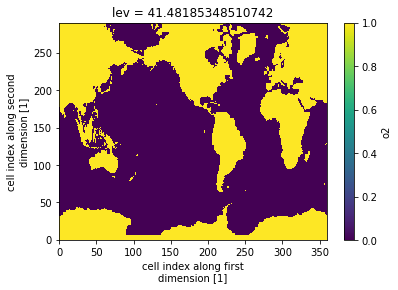

Remove bottom values
Remove ML
Check if ocean volume is conserved...


/home/samjd/anaconda3/envs/cmip6_omz/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/home/samjd/anaconda3/envs/cmip6_omz/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


Relative difference ocean vol: 64.34531950033853% | OMZ vol [ 6.01902981  7.29993782  8.47224916  9.57064427 11.4561804  13.97279476]%
Volume differences exceed threshold. NOT SAVING.
"red"
Plotting failed with: name 'ds_sigma_reloaded' is not defined
Time passed: 33.0280712723732 minutes


In [182]:
for name, ds in ddict_detrended.items():
    required_vars = ["thetao", "so", "o2", "dz_t"]#"areacello", 
    if not all(
        [va in ds.variables for va in required_vars]
    ):
        print(f"!!!\nMissing Variables {name}\n!!!")
        print([va for va in list(ds.variables) if va in required_vars])
    else:
        print(f"@@@@@@@@@@@@@@@@@\nProcessing {name}\n@@@@@@@@@@@@@@@@@")

        dataset_id = f"{cmip6_dataset_id(ds)}_{ds.attrs['variant_label']}"
        filename = ofolder.joinpath(f"{dataset_id}.zarr")

        t0 = time.time()
        if file_exist_check(filename) and not overwrite:
            print("Skipping. File exists already.")
            ds_sigma_reloaded = xr.open_zarr(
                filename, use_cftime=True, consolidated=True
            )
            try:
                plot_omz_results(ds_sigma_reloaded)
            except Exception as e:
                print(f"Plotting failed with: {e}")
        else:

            print(f"Writing to {filename}")

            tempfilelist = []

            plt.figure()
            ds.isel(time=200, lev=10).thetao.plot()
            plt.show()

            ## make sure the variables have been detrended (control run should not be)

            for va in [vv for vv in ds.data_vars if vv != "mlotst"]:
                print(va)
                #if ds.attrs["experiment_id"] == "piControl":
                #    assert "detrended_with_file" not in ds[va].attrs.keys()
                #else:
                #    assert "detrended_with_file" in ds[va].attrs.keys()

            # make sure the area has not been interpolated. I think the thickness is ok?
            for va in ["areacello"]:
                if va in ds.variables:
                    assert (
                        "horizontally_regridded_from_grid_label" not in ds[va].attrs.keys()
                    )

            if ds.attrs["experiment_id"] == "piControl":
                ds = ds.isel(time=slice(-300 * 12, None))

            ds = preprocessing_wrapper(ds)
            
            print('First temp save')
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")

                ds, tempfilelist_var = temp_write_split(
                    ds,
                    tempfolder,
                    method='dimension',
                    verbose=True,
                    split_interval=12*10 if len(ds.x) < 700 else 12*1, # 2 years worked fine with ESM4 but for CM4 I just reduced it again..
                    file_name_pattern='raw_intermediate'
                )
                tempfilelist.extend(tempfilelist_var)

            print("Rechunking incoming dataset")
            with ProgressBar():
                temppath = tempfolder.joinpath("rechunked_intermediate.zarr")
                ds = save_and_reload_rechunker(ds.astype(np.float32), path=temppath)
                tempfilelist.append(temppath)

            # I need to align.mask the thickness aswell!
            ds = ds.reset_coords(["dz_t"])
            print("masking all fields consistently")
            with ProgressBar():
                ds = align_missing(ds)

            print(f"Remove bottom values")
            ds = remove_bottom_values(ds)

            print(f"Remove ML")
            ds = mixed_layer_wrapper(ds)

            ds = ds.set_coords("dz_t")

            ds["omz_thickness"] = omz_thickness(
                ds, o2_bins=o2_bins
            )

            ds["sigma_0"] = (fastjmd95.rho(ds.so, ds.thetao, 0) - 1000)
            
            ds_sigma_monthly = transform_wrapper_again(ds)

            perc_difference, omz_perc_difference = volume_consistency_checks(
                ds, ds_sigma_monthly
            )

            print(
                f"Relative difference ocean vol: {abs(perc_difference).data}% | OMZ vol {abs(omz_perc_difference).data}%"
            )

            if (abs(perc_difference) > 0.1).any() or (
                abs(omz_perc_difference) > 0.25# Had to increase for ESM4 before most would pass 0.01
            ).any():
                print("Volume differences exceed threshold. NOT SAVING.")
                print('\x1b[31m"red"\x1b[0m')
            else:
                ds_sigma_yearly = strip_encoding(resample_yearly(ds_sigma_monthly))
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")

                    ds_sigma_yearly, tempfilelist_var = temp_write_split(
                        ds_sigma_yearly,
                        tempfolder,
                        verbose=True,
                        method='dimension',
                        split_interval=3,
                    )
                    tempfilelist.extend(tempfilelist_var)

                # rechunk the resulting file for convenience
                ds_sigma_yearly = strip_encoding(
                    ds_sigma_yearly.chunk({"x": -1, "y": -1, "time": 2})
                )

                #################### write out results ########################
                with ProgressBar():
                    ds_sigma_reloaded = write(
                        ds_sigma_yearly,
                        filename,
                        overwrite=overwrite,
                        force_load=False,
                        check_zarr_complete=True,
                    )
            ###### delete temps ######
            for tf in tempfilelist:
                if tf.exists():
                    shutil.rmtree(tf)
            ##################### Verification plotting ##########################
            try:
                plot_omz_results(ds_sigma_reloaded)
            except Exception as e:
                print(f"Plotting failed with: {e}")
        plt.show()
        t1 = time.time()
        print(f"Time passed: {(t1-t0)/60} minutes")

In [ ]:
ds = xr.open_zarr('../../data/processed/density_remapping_time_yearly_final/CMIP.CCCma.CanESM5.historical.r1i1p1f1.Omon.gn.v20190429_r1i1p1f1.zarr')

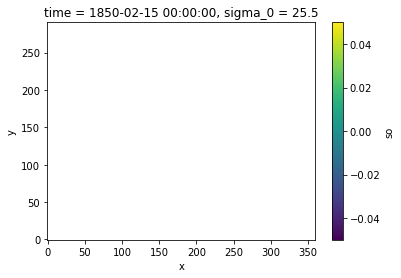

In [188]:
ds_sigma_monthly.so.isel(time = 1, sigma_0 = 1).plot()

In [199]:
np.nanmax(ds.omz_thickness.isel(time = 1, o2_bin = 1))

0.0